In [27]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
TARGET_COL = "genre_top"
N_SPLITS = 3

## Load merged dataset

In [3]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [4]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 41)
(1374, 41)


In [5]:
count_genre_top = df_train[TARGET_COL].value_counts()
rare_labels = count_genre_top[count_genre_top < 100].index
df_train = df_train[~df_train[TARGET_COL].isin(rare_labels)].copy()
print(df_train.shape)

df_test = df_test[~df_test[TARGET_COL].isin(rare_labels)].copy()
print(df_test.shape)

(5290, 41)
(1324, 41)


In [6]:
label_encoder = LabelEncoder()
df_train["genre_top"] = label_encoder.fit_transform(df_train["genre_top"])
df_test["genre_top"] = label_encoder.transform(df_test["genre_top"])

mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(mapping)

{'Classical': np.int64(0), 'Electronic': np.int64(1), 'Folk': np.int64(2), 'Hip-Hop': np.int64(3), 'Jazz': np.int64(4), 'Old-Time / Historic': np.int64(5), 'Pop': np.int64(6), 'Rock': np.int64(7)}


In [7]:
X_train, X_test = df_train.drop(columns=[TARGET_COL]), df_test.drop(columns=[TARGET_COL])
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

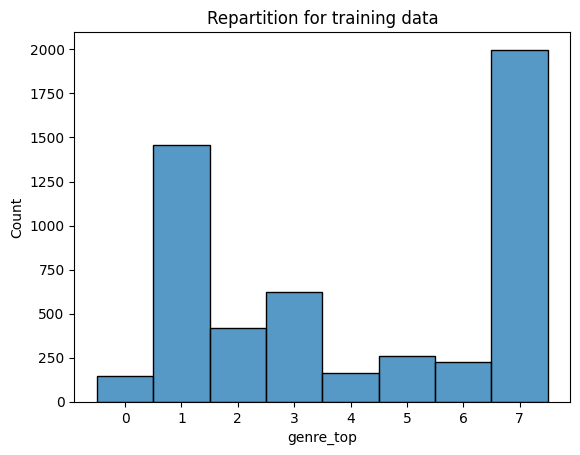

In [8]:
ax = sns.histplot(y_train, discrete=True)
ax.set_title("Repartition for training data")
plt.show()

## Model training

In [9]:
k_fold = KFold(N_SPLITS)

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

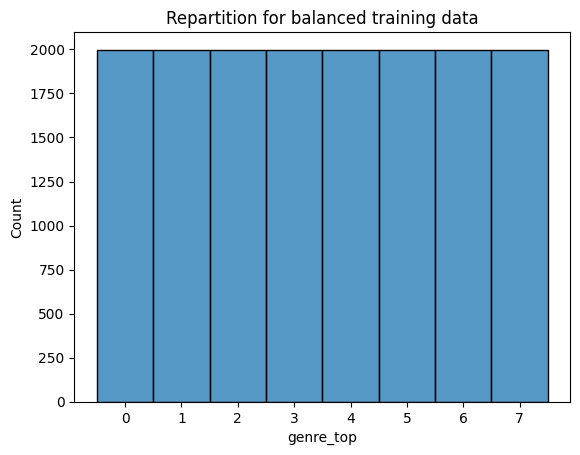

In [11]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ax = sns.histplot(y_train_balanced, discrete=True)
ax.set_title("Repartition for balanced training data")
plt.show()

### SVM

#### Training with basic hyperparams

In [28]:
svc = SVC(
    random_state=42,
    class_weight=class_weights_dict,
)

svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
accuracy_svm = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.14      0.32      0.20        37
           1       0.59      0.13      0.22       364
           2       0.16      0.56      0.25       106
           3       0.19      0.31      0.23       156
           4       0.00      0.00      0.00        40
           5       0.45      0.66      0.53        65
           6       0.09      0.12      0.11        56
           7       0.63      0.43      0.51       500

    accuracy                           0.33      1324
   macro avg       0.28      0.32      0.26      1324
weighted avg       0.47      0.33      0.34      1324



In [13]:
svc = SVC(
    random_state=42,
    class_weight=class_weights_dict,
)

svc.fit(X_train_balanced, y_train_balanced)
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.26      0.84      0.39        37
           1       1.00      0.00      0.00       364
           2       0.00      0.00      0.00       106
           3       1.00      0.00      0.00       156
           4       0.04      0.60      0.08        40
           5       0.75      0.83      0.79        65
           6       0.06      0.61      0.11        56
           7       1.00      0.00      0.00       500

    accuracy                           0.11      1324
   macro avg       0.51      0.36      0.17      1324
weighted avg       0.82      0.11      0.06      1324



### Random Forest

#### Training with basic hyperparams

In [14]:
random_forest = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights_dict,
)

random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.73      0.77      0.75       364
           2       0.66      0.38      0.48       106
           3       0.85      0.65      0.73       156
           4       0.89      0.20      0.33        40
           5       1.00      0.97      0.98        65
           6       0.80      0.07      0.13        56
           7       0.70      0.89      0.78       500

    accuracy                           0.74      1324
   macro avg       0.80      0.60      0.62      1324
weighted avg       0.75      0.74      0.71      1324



In [15]:
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_balanced, y_train_balanced)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82        37
           1       0.77      0.74      0.76       364
           2       0.50      0.65      0.57       106
           3       0.73      0.78      0.76       156
           4       0.46      0.45      0.46        40
           5       0.98      0.98      0.98        65
           6       0.38      0.36      0.37        56
           7       0.81      0.77      0.79       500

    accuracy                           0.74      1324
   macro avg       0.68      0.70      0.69      1324
weighted avg       0.75      0.74      0.74      1324



#### Training with hyperparams optimization

In [16]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [17]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= k_fold,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  10.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  10.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  10.7s
[CV] END max_depth=10, min_sa

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [18]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (based on training data): 0.6509
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        37
           1       0.78      0.73      0.75       364
           2       0.51      0.65      0.57       106
           3       0.76      0.79      0.77       156
           4       0.48      0.53      0.50        40
           5       1.00      0.98      0.99        65
           6       0.45      0.43      0.44        56
           7       0.81      0.77      0.79       500

    accuracy                           0.75      1324
   macro avg       0.69      0.73      0.71      1324
weighted avg       0.75      0.75      0.75      1324



In [19]:
best_params = grid_search.best_params_
random_forest = RandomForestClassifier(random_state=42, **best_params)

scores = cross_validate(random_forest, X_train_balanced, y_train_balanced, cv=k_fold, scoring="accuracy")
rf_mean_score = round(np.mean(scores["test_score"]), 3)
rf_mean_fit_time = round(np.mean(scores["fit_time"]), 3)
print("Accuracy:", rf_mean_score, "+-", round(np.std(scores["test_score"]), 3))
print("Fit time:", rf_mean_fit_time, "+-", round(np.std(scores["fit_time"]), 3))

Accuracy: 0.651 +- 0.14
Fit time: 9.111 +- 0.497


### XGBoost

#### Training with basic hyperparams

In [20]:
xgb = XGBClassifier(random_state=42)

sample_weights = y_train.map(class_weights_dict)

xgb.fit(X_train, y_train, sample_weight=sample_weights)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        37
           1       0.78      0.81      0.80       364
           2       0.71      0.63      0.67       106
           3       0.81      0.78      0.79       156
           4       0.77      0.68      0.72        40
           5       0.97      0.97      0.97        65
           6       0.65      0.39      0.49        56
           7       0.81      0.86      0.83       500

    accuracy                           0.80      1324
   macro avg       0.79      0.74      0.76      1324
weighted avg       0.79      0.80      0.79      1324

[[ 31   1   2   0   0   1   0   2]
 [  0 295   7  11   2   0   1  48]
 [  1   8  67   2   1   1   3  23]
 [  0  23   1 121   1   0   1   9]
 [  4   2   2   0  27   0   0   5]
 [  2   0   0   0   0  63   0   0]
 [  0   9   8   3   0   0  22  14]
 [  0  40   8  12   4   0   7 429]]


In [21]:
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_balanced, y_train_balanced)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.80      0.80      0.80       364
           2       0.65      0.62      0.64       106
           3       0.85      0.81      0.83       156
           4       0.58      0.62      0.60        40
           5       0.97      0.98      0.98        65
           6       0.45      0.41      0.43        56
           7       0.82      0.83      0.82       500

    accuracy                           0.79      1324
   macro avg       0.74      0.74      0.74      1324
weighted avg       0.79      0.79      0.79      1324

[[ 32   1   0   0   1   1   0   2]
 [  1 292   9  10   4   0  10  38]
 [  1   4  66   3   0   1   6  25]
 [  0  16   1 126   2   0   1  10]
 [  4   3   5   0  25   0   0   3]
 [  1   0   0   0   0  64   0   0]
 [  0  10   3   3   1   0  23  16]
 [  0  38  17   7  10   0  11 417]]


#### Training with hyperparams optimization

In [22]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

In [23]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= k_fold,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   5.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   5.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   5.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   5.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, subsample=0.9; tota

/Users/antoinekerboul/Documents/IMT_Atlantique/4A/FML/Challenges/supervised-challenge/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  11.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  11.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.7; total time=  10.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.9; total time=  10.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.7; total time=  11.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.9; total time=  11.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.7; total time=  11.6s
[CV] END colsample_bytree=0.7, learning_r

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 5], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [24]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}
Best CV score (based on training data): 0.7470
              precision    recall  f1-score   support

           0       0.82      0.89      0.86        37
           1       0.80      0.81      0.80       364
           2       0.69      0.67      0.68       106
           3       0.84      0.82      0.83       156
           4       0.67      0.70      0.68        40
           5       0.98      0.98      0.98        65
           6       0.56      0.52      0.54        56
           7       0.83      0.83      0.83       500

    accuracy                           0.80      1324
   macro avg       0.77      0.78      0.78      1324
weighted avg       0.80      0.80      0.80      1324



In [25]:
best_params = grid_search.best_params_
xgb = XGBClassifier(random_state=42, **best_params)

scores = cross_validate(xgb, X_train_balanced, y_train_balanced, cv=k_fold, scoring="accuracy")
xgb_mean_score = round(np.mean(scores["test_score"]), 3)
xgb_mean_fit_time = round(np.mean(scores["fit_time"]), 3)
print("Accuracy:", xgb_mean_score, "+-", round(np.std(scores["test_score"]), 3))
print("Fit time:", xgb_mean_fit_time, "+-", round(np.std(scores["fit_time"]), 3))

Accuracy: 0.747 +- 0.151
Fit time: 9.18 +- 1.144


## Comparaison

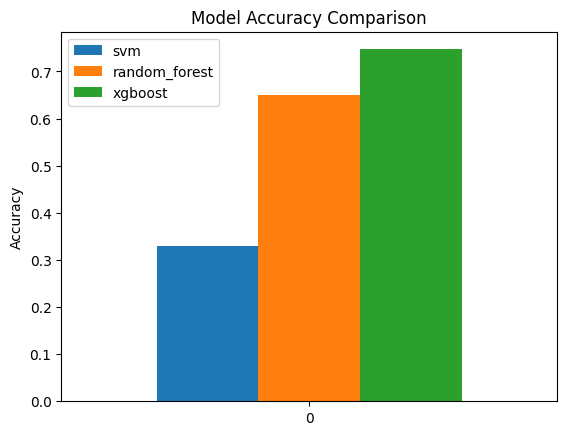

In [34]:
pd.DataFrame({
    "svm": [accuracy_svm],
    "random_forest": [rf_mean_score],
    "xgboost": [xgb_mean_score],
}).plot(kind='bar', rot=0, title="Model Accuracy Comparison", width=0.8)
plt.ylabel("Accuracy")
plt.show()

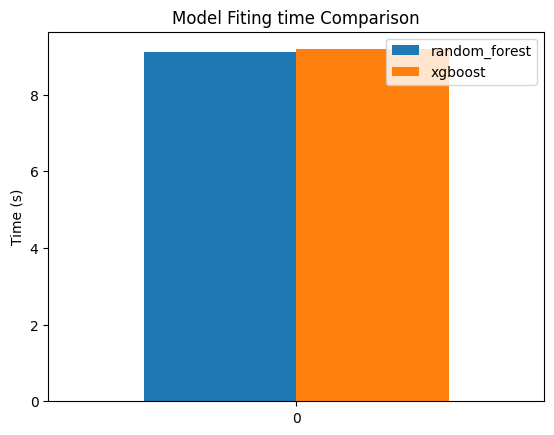

In [37]:
pd.DataFrame({
    "random_forest": [rf_mean_fit_time],
    "xgboost": [xgb_mean_fit_time],
}).plot(kind='bar', rot=0, title="Model Fiting time Comparison", width=0.8)
plt.ylabel("Time (s)")
plt.show()